This is a home price model using advanced regression techniques and the Ames database.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV, LassoCV, LassoLarsCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

Remove columns deemed unlikely to be helpful using a heatmap.

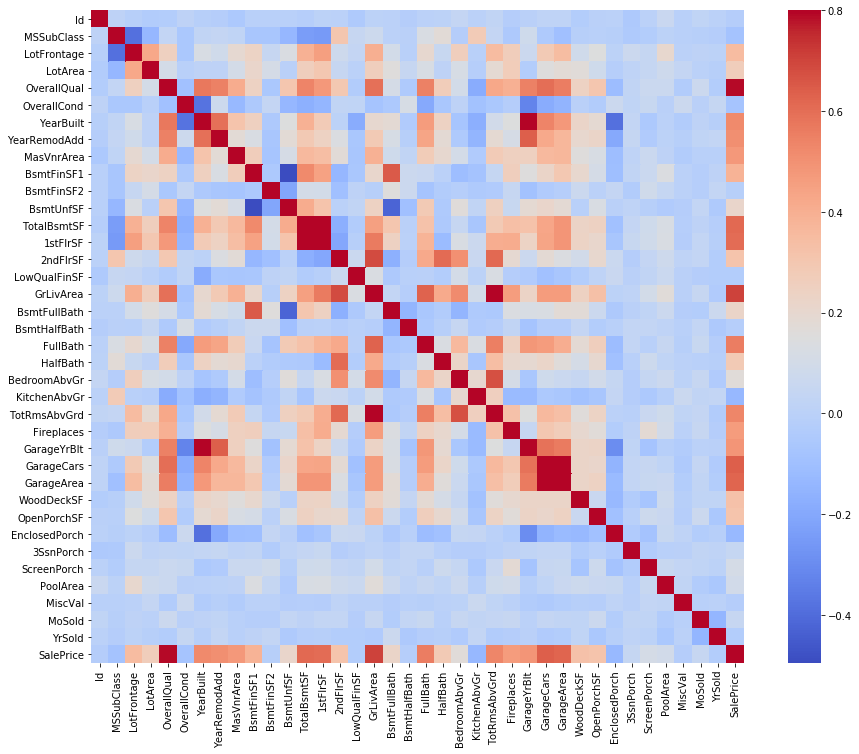

In [3]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.8, square=True, cmap= 'coolwarm');

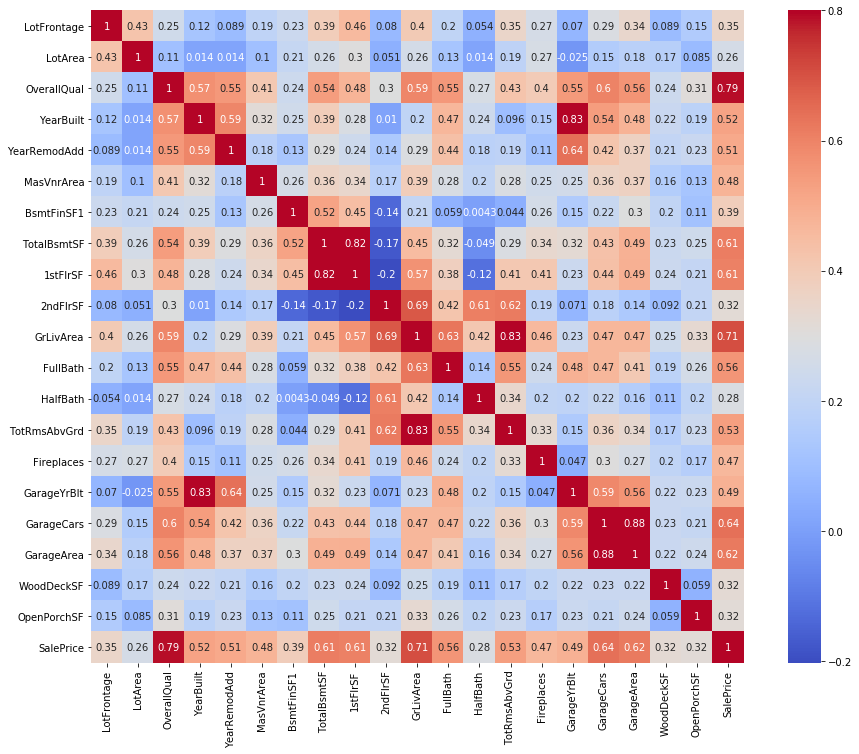

In [4]:
#Lose because badly correlated with SalePrice: 'Id', 'MSSubClass', 'OverallCond', 'BsmtFinSF2','BsmtUnfSF','LowQualFinSF','BsmtFullBath','BsmtHalfBath','BedroomAbvGrd','KitchenAbvGr', 'EnclosedPorch', '3SsnPorch','MoSold','YrSold'.
df_train_R = df_train.copy()
df_train_R.drop(['Id', 'MSSubClass', 'OverallCond', 'BsmtFinSF2','BsmtUnfSF','LowQualFinSF','BsmtFullBath','BsmtHalfBath','BedroomAbvGr','KitchenAbvGr', 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold'], axis=1, inplace=True)

#Then check again, this time with annotations
corrmat = df_train_R.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.8,  annot=True, square=True, cmap= 'coolwarm');

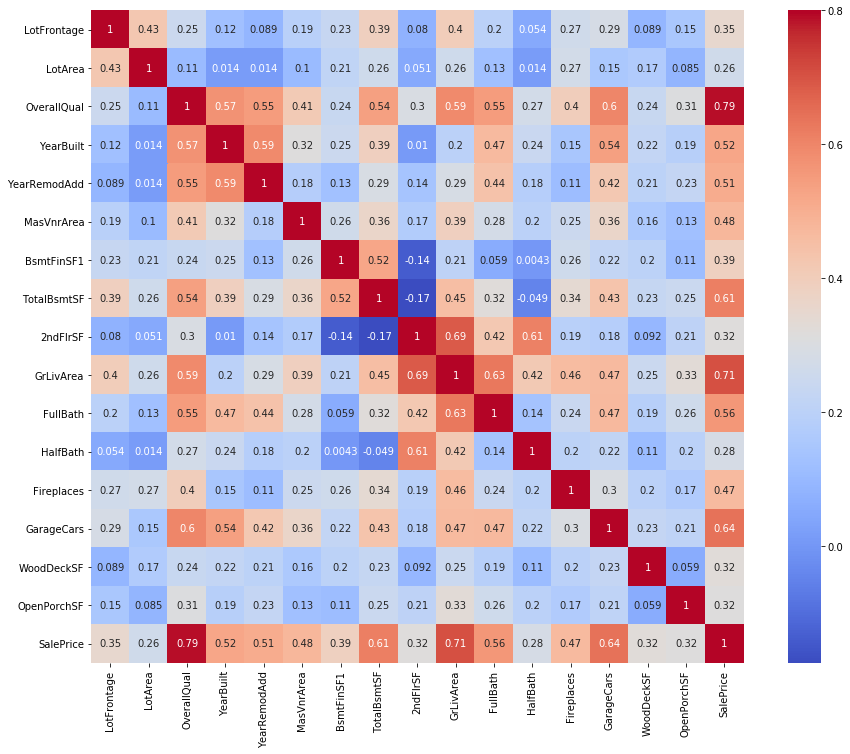

In [5]:
#Lose because redundant
df_train_R.drop(['GarageYrBlt','GarageArea','TotRmsAbvGrd','1stFlrSF'], axis=1, inplace=True)

#Then check again
corrmat = df_train_R.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.8,  annot=True, square=True, cmap= 'coolwarm');

In [6]:
#Turn Street into a Pave yes/no one hot
Street = pd.get_dummies(df_train_R['Street'])
df_train_R['Street'] = Street['Pave']

#Turn LotShape into a Reg yes/no one hot
LotShape = pd.get_dummies(df_train_R['LotShape'])
df_train_R['LotShape'] = 1-LotShape['Reg']

#Turn LandContour into a Lvl yes/no one hot
LandContour = pd.get_dummies(df_train_R['LandContour'])
df_train_R['LandContour'] = LandContour['Lvl']

#Turn Utilities into an AllPub yes/no one hot
Utilities = pd.get_dummies(df_train_R['Utilities'])
df_train_R['Utilities'] = Utilities['AllPub']

#Turn LandSlope into an Gtl yes/no one hot
LandSlope = pd.get_dummies(df_train_R['LandSlope'])
df_train_R['LandSlope'] = LandSlope['Gtl']

#Turn MasVnrType into an None yes/no one hot
MasVnrType = pd.get_dummies(df_train_R['MasVnrType'])
df_train_R['MasVnrType'] = 1-MasVnrType['None']

#Turn BsmtExposure into a one hot
BsmtExposure = pd.get_dummies(df_train_R['BsmtExposure'])
df_train_R['BsmtExposure'] = 1-BsmtExposure['No']

#Turn PavedDrive to a Y one hot encode
PavedDrive = pd.get_dummies(df_train_R['PavedDrive'])
df_train_R['PavedDrive'] = PavedDrive['Y']

#Turn GarageFinish into a RFn one hot encode
GarageFinish = pd.get_dummies(df_train_R['GarageFinish'])
df_train_R['GarageFinish'] = GarageFinish['RFn']

#Turn CentralAir to a one hot encode
CentralAir = pd.get_dummies(df_train_R['CentralAir'])
df_train_R['CentralAir'] = CentralAir['Y']

In [7]:
#Turn Alley into a weighted numerical value
Alley = pd.get_dummies(df_train_R['Alley'])
df_train_R['Alley'] = Alley['Grvl']+2*Alley['Pave']

#Turn RoofMatl into a weighted numerical value by grouping premium materials
RoofMatl = pd.get_dummies(df_train_R['RoofMatl'])
df_train_R['RoofMatl'] = RoofMatl['CompShg']+2*RoofMatl['WdShngl']+2*RoofMatl['WdShake']+2*RoofMatl['ClyTile']

#Turn Exterior1st into a weighted numerical value by grouping premium materials
Exterior1st = pd.get_dummies(df_train_R['Exterior1st'])
df_train_R['Exterior1st'] = Exterior1st['ImStucc']+Exterior1st['Wd Sdng']+Exterior1st['Stucco']+Exterior1st['VinylSd']+Exterior1st['CemntBd']+Exterior1st['HdBoard']+2*Exterior1st['WdShing']+2*Exterior1st['BrkComm']+2*Exterior1st['BrkFace']+2*Exterior1st['Stone']

#Turn Exterior2nd into a weighted numerical value by grouping premium materials
Exterior2nd = pd.get_dummies(df_train_R['Exterior2nd'])
df_train_R['Exterior2nd'] = Exterior2nd['ImStucc']+Exterior2nd['Wd Sdng']+Exterior2nd['Stucco']+Exterior2nd['VinylSd']+Exterior2nd['CmentBd']+Exterior2nd['HdBoard']+2*Exterior2nd['Wd Shng']+2*Exterior2nd['Brk Cmn']+2*Exterior2nd['BrkFace']+2*Exterior2nd['Stone']

In [8]:
#There are many quality/condition columns that run from Ex,Gd,TA,Fa,Po so let's give them values of 10, 8, 5, 2, and 0 respectively. 
#let's use variables so we can adjust later easily if things don't look right. Take NA on a case by case basis.


Ex = 10
Gd = 8
TA = 5
Fa = 2

ExterQual = pd.get_dummies(df_train_R['ExterQual'])
df_train_R['ExterQual'] = Fa*ExterQual['Fa']+TA*ExterQual['TA']+Gd*ExterQual['Gd']+Ex*ExterQual['Ex']
ExterCond = pd.get_dummies(df_train_R['ExterCond'])
df_train_R['ExterCond'] = Fa*ExterCond['Fa']+TA*ExterCond['TA']+Gd*ExterCond['Gd']+Ex*ExterCond['Ex']

BsmtQual = pd.get_dummies(df_train_R['BsmtQual'])
df_train_R['BsmtQual'] = Fa*BsmtQual['Fa']+TA*BsmtQual['TA']+Gd*BsmtQual['Gd']+Ex*BsmtQual['Ex']
BsmtCond = pd.get_dummies(df_train_R['BsmtCond'])
df_train_R['BsmtCond'] = Fa*BsmtCond['Fa']+TA*BsmtCond['TA']+Gd*BsmtCond['Gd'] #+Ex*BsmtCond['Ex']

HeatingQC = pd.get_dummies(df_train_R['HeatingQC'])
df_train_R['HeatingQC'] = Fa*HeatingQC['Fa']+TA*HeatingQC['TA']+Gd*HeatingQC['Gd']+Ex*HeatingQC['Ex']

KitchenQual = pd.get_dummies(df_train_R['KitchenQual'])
df_train_R['KitchenQual'] = Fa*KitchenQual['Fa']+TA*KitchenQual['TA']+Gd*KitchenQual['Gd']+Ex*KitchenQual['Ex']

FireplaceQu = pd.get_dummies(df_train_R['FireplaceQu'])
df_train_R['FireplaceQu'] = Fa*FireplaceQu['Fa']+TA*FireplaceQu['TA']+Gd*FireplaceQu['Gd']+Ex*FireplaceQu['Ex']

GarageQual = pd.get_dummies(df_train_R['GarageQual'])
df_train_R['GarageQual'] = Fa*GarageQual['Fa']+TA*GarageQual['TA']+Gd*GarageQual['Gd']+Ex*GarageQual['Ex']
GarageCond = pd.get_dummies(df_train_R['GarageCond'])
df_train_R['GarageCond'] = Fa*GarageCond['Fa']+TA*GarageCond['TA']+Gd*GarageCond['Gd']+Ex*GarageCond['Ex']

PoolQC = pd.get_dummies(df_train_R['PoolQC'])
df_train_R['PoolQC'] = Fa*PoolQC['Fa']+Gd*PoolQC['Gd']+Ex*PoolQC['Ex']   #+TA*PoolQC['TA']

Now look again.

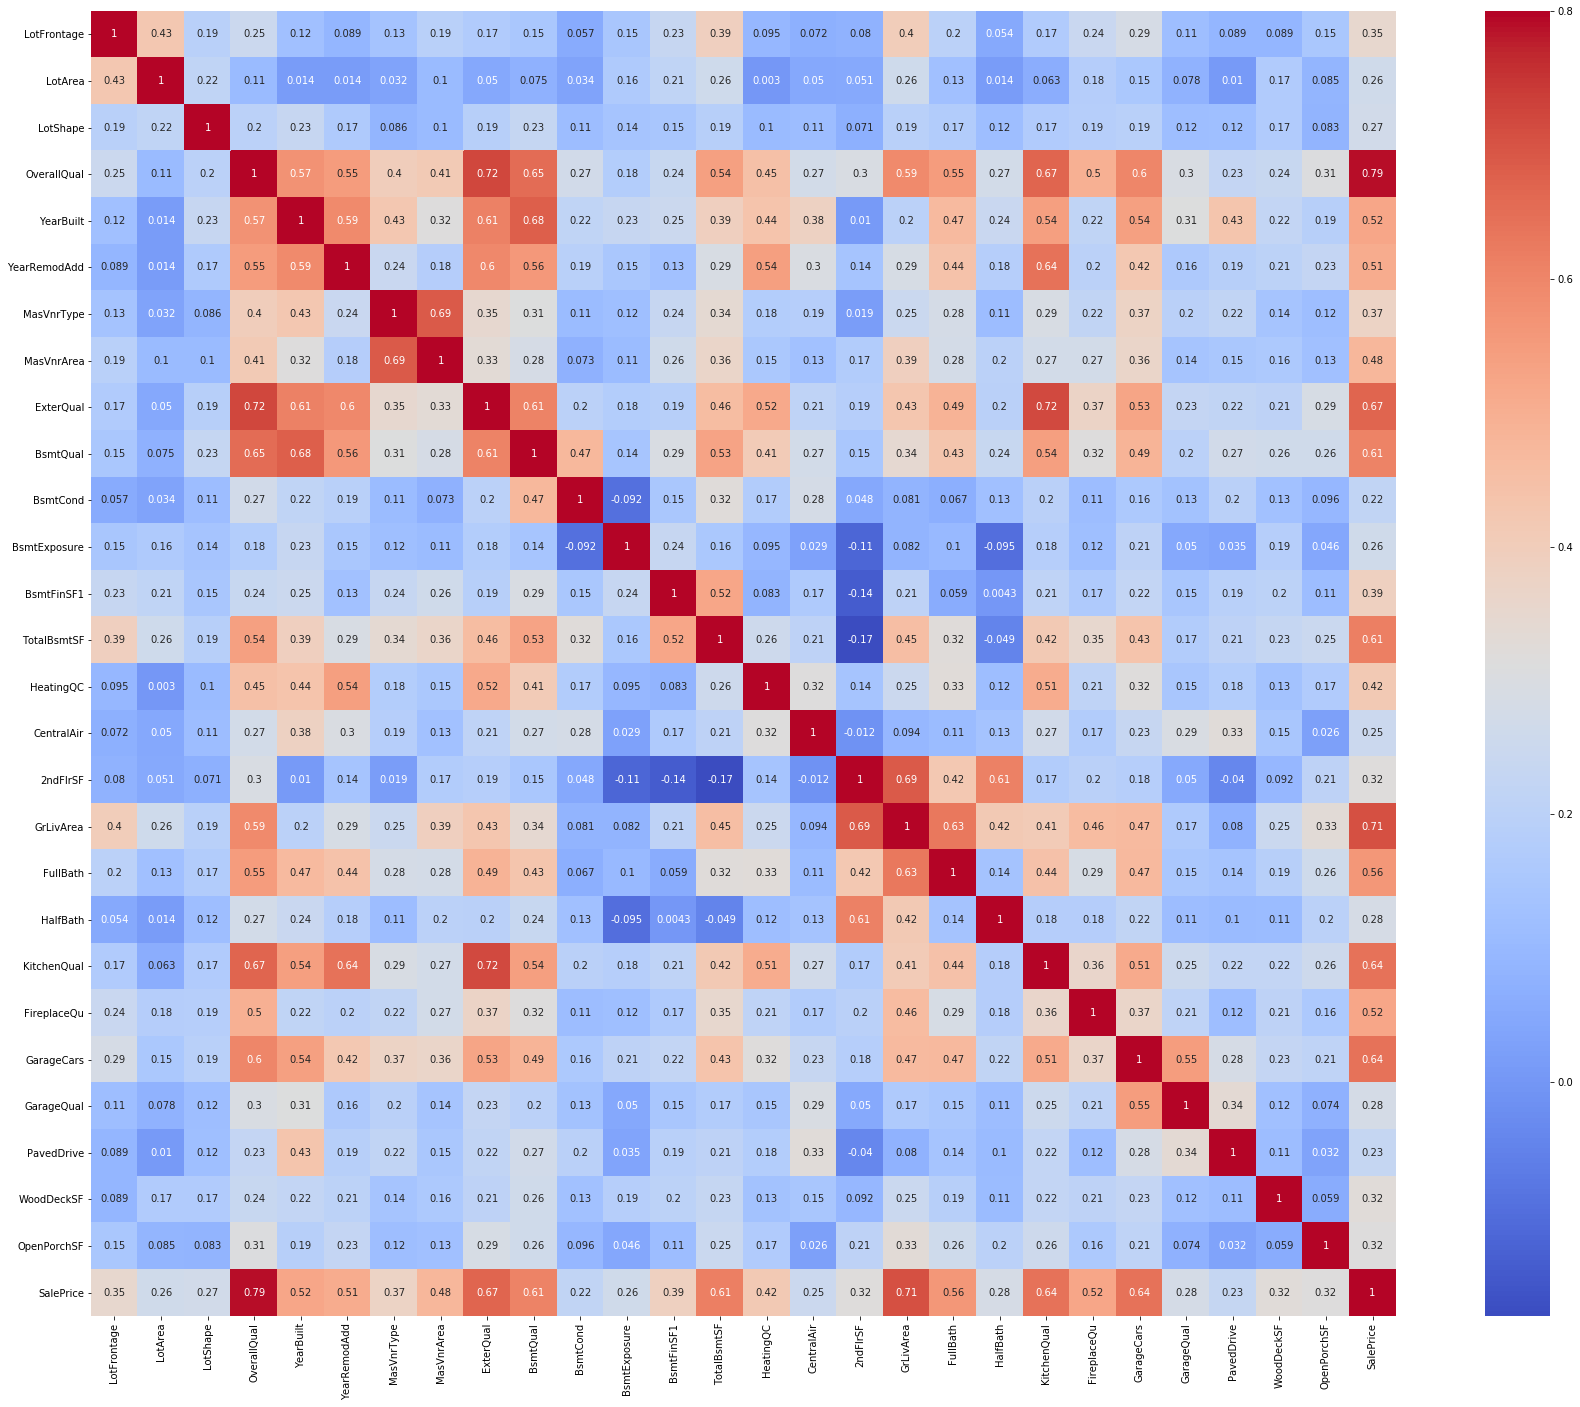

In [13]:
corrmat = df_train_R.corr()
f, ax = plt.subplots(figsize=(32, 24))
sns.heatmap(corrmat, vmax=.8,  annot=True, square=True, cmap= 'coolwarm');

Let's drop Street, GarageFinish, Alley, LandSlope, LandContour, ExterCond, PoolQC, RoofMatl, Exterior1st, Exterior2nd, and Utilities for poor correlation and GarageCond and fireplaces for redundancy.

In [12]:
df_train_R.drop('Street', axis=1, inplace=True)
df_train_R.drop('GarageFinish', axis=1, inplace=True)
df_train_R.drop('Alley', axis=1, inplace=True)
df_train_R.drop('LandSlope', axis=1, inplace=True)
df_train_R.drop('LandContour', axis=1, inplace=True)
df_train_R.drop('ExterCond', axis=1, inplace=True)
df_train_R.drop('PoolQC', axis=1, inplace=True)
df_train_R.drop('Utilities', axis=1, inplace=True)
df_train_R.drop('GarageCond', axis=1, inplace=True)
df_train_R.drop('Fireplaces', axis=1, inplace=True)
df_train_R.drop('RoofMatl', axis=1, inplace=True)
df_train_R.drop('Exterior1st', axis=1, inplace=True)
df_train_R.drop('Exterior2nd', axis=1, inplace=True)

Now let's see if we can remove obvious outliers.

Text(0.5, 1.0, 'LotFrontage vs. Sale Price')

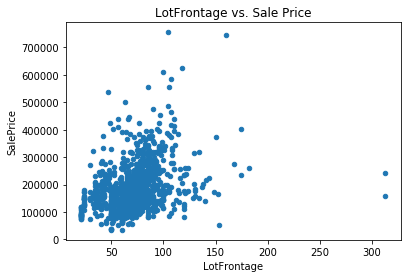

In [14]:
df_train_R.plot.scatter('LotFrontage', 'SalePrice')
plt.title('LotFrontage vs. Sale Price')

Text(0.5, 1.0, 'LotArea vs. Sale Price')

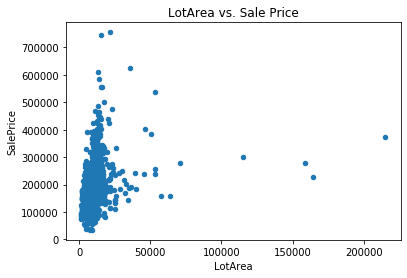

In [34]:
df_train_R.plot.scatter('LotArea', 'SalePrice')
plt.title('LotArea vs. Sale Price')

Text(0.5, 1.0, 'LotShape vs. Sale Price')

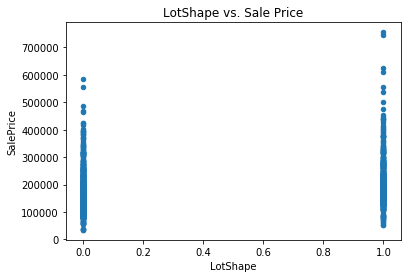

In [15]:
df_train_R.plot.scatter('LotShape', 'SalePrice')
plt.title('LotShape vs. Sale Price')

Text(0.5, 1.0, 'OverallQual vs. Sale Price')

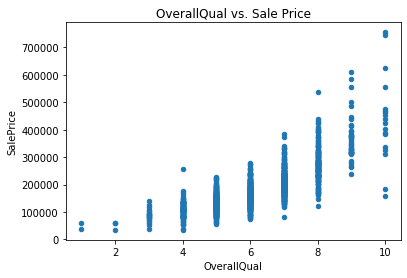

In [16]:
df_train_R.plot.scatter('OverallQual', 'SalePrice')
plt.title('OverallQual vs. Sale Price')

Text(0.5, 1.0, 'YearBuilt vs. Sale Price')

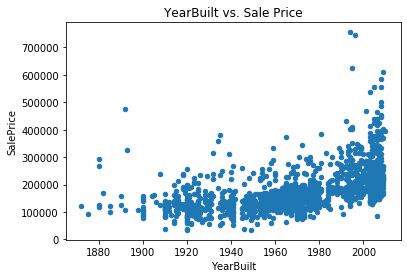

In [17]:
df_train_R.plot.scatter('YearBuilt', 'SalePrice')
plt.title('YearBuilt vs. Sale Price')

Text(0.5, 1.0, 'YearRemodAdd vs. Sale Price')

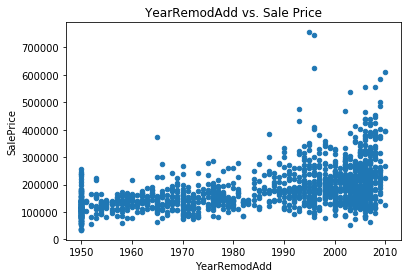

In [18]:
df_train_R.plot.scatter('YearRemodAdd', 'SalePrice')
plt.title('YearRemodAdd vs. Sale Price')

Text(0.5, 1.0, 'MasVnrType vs. Sale Price')

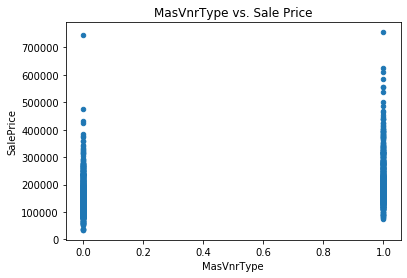

In [19]:
df_train_R.plot.scatter('MasVnrType', 'SalePrice')
plt.title('MasVnrType vs. Sale Price')

Text(0.5, 1.0, 'MasVnrArea vs. Sale Price')

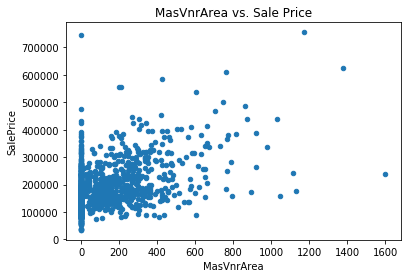

In [20]:
df_train_R.plot.scatter('MasVnrArea', 'SalePrice')
plt.title('MasVnrArea vs. Sale Price')

Text(0.5, 1.0, 'ExterQual vs. Sale Price')

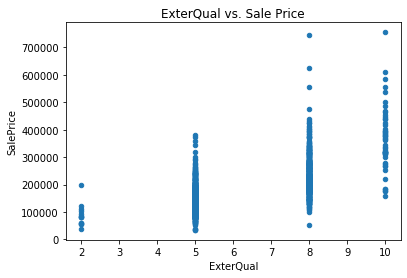

In [21]:
df_train_R.plot.scatter('ExterQual', 'SalePrice')
plt.title('ExterQual vs. Sale Price')

Text(0.5, 1.0, 'BsmtQual vs. Sale Price')

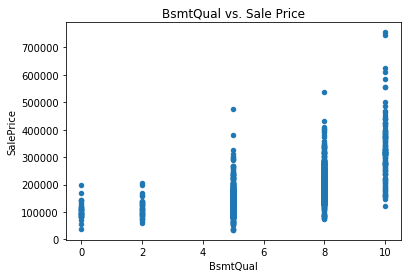

In [22]:
df_train_R.plot.scatter('BsmtQual', 'SalePrice')
plt.title('BsmtQual vs. Sale Price')

Text(0.5, 1.0, 'BsmtFinSF1 vs. Sale Price')

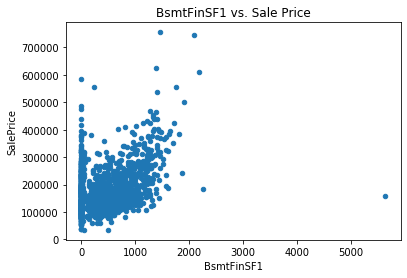

In [23]:
df_train_R.plot.scatter('BsmtFinSF1', 'SalePrice')
plt.title('BsmtFinSF1 vs. Sale Price')

Text(0.5, 1.0, 'TotalBsmtSF vs. Sale Price')

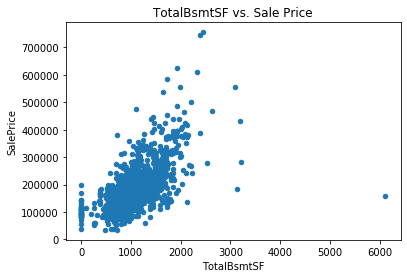

In [24]:
df_train_R.plot.scatter('TotalBsmtSF', 'SalePrice')
plt.title('TotalBsmtSF vs. Sale Price')

Text(0.5, 1.0, '2ndFlrSF vs. Sale Price')

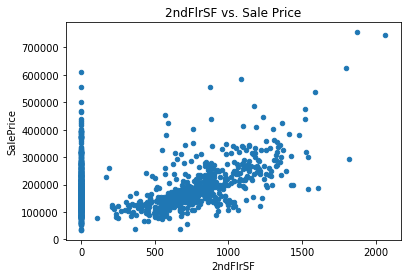

In [25]:
df_train_R.plot.scatter('2ndFlrSF', 'SalePrice')
plt.title('2ndFlrSF vs. Sale Price')

Text(0.5, 1.0, 'GrLivArea vs. Sale Price')

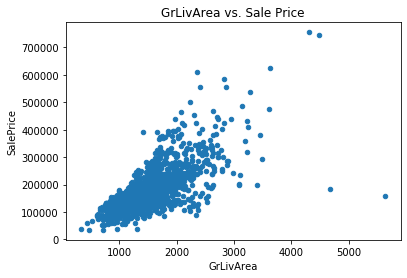

In [26]:
df_train_R.plot.scatter('GrLivArea', 'SalePrice')
plt.title('GrLivArea vs. Sale Price')

Text(0.5, 1.0, 'FullBath vs. Sale Price')

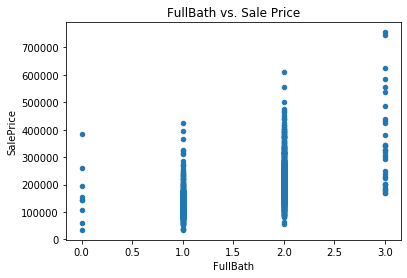

In [27]:
df_train_R.plot.scatter('FullBath', 'SalePrice')
plt.title('FullBath vs. Sale Price')

Text(0.5, 1.0, 'HalfBath vs. Sale Price')

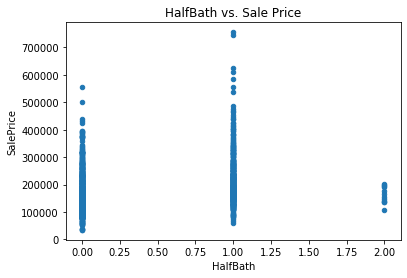

In [28]:
df_train_R.plot.scatter('HalfBath', 'SalePrice')
plt.title('HalfBath vs. Sale Price')

Text(0.5, 1.0, 'FireplaceQu vs. Sale Price')

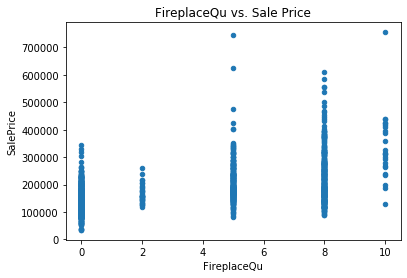

In [30]:
df_train_R.plot.scatter('FireplaceQu', 'SalePrice')
plt.title('FireplaceQu vs. Sale Price')

Text(0.5, 1.0, 'GarageCars vs. Sale Price')

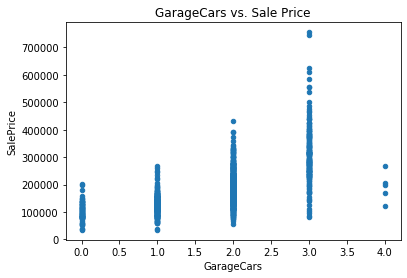

In [31]:
df_train_R.plot.scatter('GarageCars', 'SalePrice')
plt.title('GarageCars vs. Sale Price')

Text(0.5, 1.0, 'WoodDeckSF vs. Sale Price')

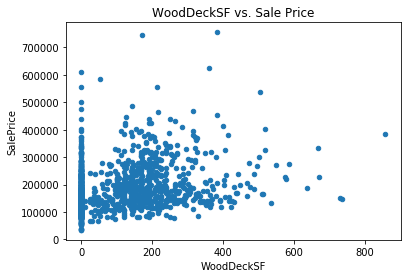

In [32]:
df_train_R.plot.scatter('WoodDeckSF', 'SalePrice')
plt.title('WoodDeckSF vs. Sale Price')

Text(0.5, 1.0, 'OpenPorchSF vs. Sale Price')

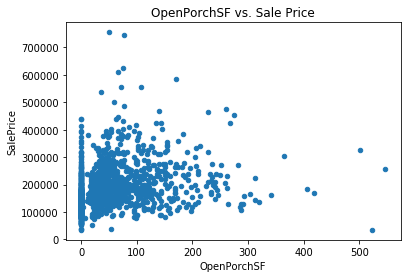

In [33]:
df_train_R.plot.scatter('OpenPorchSF', 'SalePrice')
plt.title('OpenPorchSF vs. Sale Price')

In [35]:
df_train_R = df_train_R[df_train_R.LotArea < 50000]
df_train_R = df_train_R[df_train_R.GrLivArea < 4000]
df_train_R = df_train_R[df_train_R.TotalBsmtSF < 3000]
df_train_R = df_train_R[df_train_R.GarageCars < 4]

Finally, dump all remaining catagorical data into dummies

In [37]:
df_train_R = pd.get_dummies(df_train_R)

In [38]:
#Check to see if/where we have NAs
df_train_R.isna().any()

LotFrontage               True
LotArea                  False
LotShape                 False
OverallQual              False
YearBuilt                False
YearRemodAdd             False
MasVnrType               False
MasVnrArea                True
ExterQual                False
BsmtQual                 False
BsmtCond                 False
BsmtExposure             False
BsmtFinSF1               False
TotalBsmtSF              False
HeatingQC                False
CentralAir               False
2ndFlrSF                 False
GrLivArea                False
FullBath                 False
HalfBath                 False
KitchenQual              False
FireplaceQu              False
GarageCars               False
GarageQual               False
PavedDrive               False
WoodDeckSF               False
OpenPorchSF              False
SalePrice                False
MSZoning_C (all)         False
MSZoning_FV              False
MSZoning_RH              False
MSZoning_RL              False
MSZoning

In [39]:
#While there will be some lots without frontage in rare cases, it seems more likely that these are where the 
#value is unknown. So we go with the average.  
df_train_R['LotFrontage'].fillna(df_train_R['LotFrontage'].mean(), inplace=True)

#Fill all other Nas with zero
df_train_R.fillna(0, inplace=True)

Now let's correct for skewedness on each column where needed

In [45]:
#sns.distplot(df_train_R['SalePrice'])
#sns.distplot(np.log1p(df_train_R['SalePrice']))
df_train_R['SalePrice'] = np.log1p(df_train_R['SalePrice'])

In [46]:
#sns.distplot(df_train_R['MasVnrArea'])
#sns.distplot(np.log1p(df_train_R['MasVnrArea']))
df_train_R['MasVnrArea'] = np.log1p(df_train_R['MasVnrArea'])

In [47]:
#sns.distplot(df_train_R['BsmtFinSF1'])
#sns.distplot(np.log1p(df_train_R['BsmtFinSF1']))
df_train_R['BsmtFinSF1'] = np.log1p(df_train_R['BsmtFinSF1'])

In [48]:
#sns.distplot(df_train_R['TotalBsmtSF'])
#sns.distplot(np.log1p(df_train_R['TotalBsmtSF']))
df_train_R['TotalBsmtSF'] = np.log1p(df_train_R['TotalBsmtSF'])

In [49]:
#sns.distplot(df_train_R['GrLivArea'])
#sns.distplot(np.log1p(df_train_R['GrLivArea']))
df_train_R['GrLivArea'] = np.log1p(df_train_R['GrLivArea'])

In [50]:
#sns.distplot(df_train_R['OpenPorchSF'])
#sns.distplot(np.log1p(df_train_R['OpenPorchSF']))
df_train_R['OpenPorchSF'] = np.log1p(df_train_R['OpenPorchSF'])

Now let's prepare X and y for training and testing

In [51]:
X_train = df_train_R.copy()
X_train.drop(['SalePrice'], axis=1, inplace=True)
y_train = df_train_R['SalePrice']

In [52]:
X, X_check, y, y_check = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
X = X.reset_index()
y = y.reset_index()
X_check = X_check.reset_index()
y_check = y_check.reset_index()
del X['index']
del y['index']
del X_check['index']
del y_check['index']

In [ ]:
df_train_R

In [56]:
#linreg = LinearRegression().fit(X, y)
rigCVreg = RidgeCV().fit(X,y)
#lasCVreg = LassoCV().fit(X,y)
#dtreg = DecisionTreeRegressor().fit(X,y)

In [ ]:
print(np.mean(cross_val_score(linreg, X, y, cv=10)))
print(np.mean(cross_val_score(linreg, X_check, y_check, cv=10)))

In [54]:
print(np.mean(cross_val_score(rigCVreg, X, y, cv=10)))
print(np.mean(cross_val_score(rigCVreg, X_check, y_check, cv=10)))

0.8930218037675195
0.8915547930793479


In [ ]:
print(np.mean(cross_val_score(lasCVreg, X, y, cv=10)))
print(np.mean(cross_val_score(lasCVreg, X_check, y_check, cv=10)))

In [ ]:
print(np.mean(cross_val_score(dtreg, X, y, cv=10)))
print(np.mean(cross_val_score(dtreg, X_check, y_check, cv=10)))

It looks like RigCV gives the best output. Let's try to make some improvements.

In [55]:
rigCVreg = RidgeCV(alphas=[0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50]).fit(X,y)

print(np.mean(cross_val_score(rigCVreg, X, y, cv=10)))
print(np.mean(cross_val_score(rigCVreg, X_check, y_check, cv=10)))

0.8958134465247186
0.8904432151721637


Now we repeat the data wrangling but for the test data. It would be better to do the wrangling in a function i can reuse for both sets, but I want to show my thinking, so here we go. 

In [79]:
df_test_R = df_test.copy()
df_test_R.drop(['Id', 'MSSubClass', 'OverallCond', 'BsmtFinSF2','BsmtUnfSF','LowQualFinSF','BsmtFullBath','BsmtHalfBath','BedroomAbvGr','KitchenAbvGr', 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold'], axis=1, inplace=True)
df_test_R.drop(['GarageYrBlt','GarageArea','TotRmsAbvGrd','1stFlrSF'], axis=1, inplace=True)

df_test_R.drop('Street', axis=1, inplace=True)
df_test_R.drop('GarageFinish', axis=1, inplace=True)
df_test_R.drop('Alley', axis=1, inplace=True)
df_test_R.drop('LandSlope', axis=1, inplace=True)
df_test_R.drop('LandContour', axis=1, inplace=True)
df_test_R.drop('ExterCond', axis=1, inplace=True)
df_test_R.drop('PoolQC', axis=1, inplace=True)
df_test_R.drop('Utilities', axis=1, inplace=True)
df_test_R.drop('GarageCond', axis=1, inplace=True)
df_test_R.drop('Fireplaces', axis=1, inplace=True)
df_test_R.drop('RoofMatl', axis=1, inplace=True)
df_test_R.drop('Exterior1st', axis=1, inplace=True)
df_test_R.drop('Exterior2nd', axis=1, inplace=True)

In [80]:
#Turn LotShape into a Reg yes/no one hot
LotShape = pd.get_dummies(df_test_R['LotShape'])
df_test_R['LotShape'] = 1-LotShape['Reg']

#Turn MasVnrType into an None yes/no one hot
MasVnrType = pd.get_dummies(df_test_R['MasVnrType'])
df_test_R['MasVnrType'] = 1-MasVnrType['None']

#Turn BsmtExposure into a one hot
BsmtExposure = pd.get_dummies(df_test_R['BsmtExposure'])
df_test_R['BsmtExposure'] = 1-BsmtExposure['No']

#Turn PavedDrive to a Y one hot encode
PavedDrive = pd.get_dummies(df_test_R['PavedDrive'])
df_test_R['PavedDrive'] = PavedDrive['Y']

#Turn CentralAir to a one hot encode
CentralAir = pd.get_dummies(df_test_R['CentralAir'])
df_test_R['CentralAir'] = CentralAir['Y']

Ex = 10
Gd = 8
TA = 5
Fa = 2

ExterQual = pd.get_dummies(df_test_R['ExterQual'])
df_test_R['ExterQual'] = Fa*ExterQual['Fa']+TA*ExterQual['TA']+Gd*ExterQual['Gd']+Ex*ExterQual['Ex']

BsmtQual = pd.get_dummies(df_test_R['BsmtQual'])
df_test_R['BsmtQual'] = Fa*BsmtQual['Fa']+TA*BsmtQual['TA']+Gd*BsmtQual['Gd']+Ex*BsmtQual['Ex']
BsmtCond = pd.get_dummies(df_test_R['BsmtCond'])
df_test_R['BsmtCond'] = Fa*BsmtCond['Fa']+TA*BsmtCond['TA']+Gd*BsmtCond['Gd']  #+Ex*BsmtCond['Ex']

HeatingQC = pd.get_dummies(df_test_R['HeatingQC'])
df_test_R['HeatingQC'] = Fa*HeatingQC['Fa']+TA*HeatingQC['TA']+Gd*HeatingQC['Gd']+Ex*HeatingQC['Ex']

KitchenQual = pd.get_dummies(df_test_R['KitchenQual'])
df_test_R['KitchenQual'] = Fa*KitchenQual['Fa']+TA*KitchenQual['TA']+Gd*KitchenQual['Gd']+Ex*KitchenQual['Ex']

FireplaceQu = pd.get_dummies(df_test_R['FireplaceQu'])
df_test_R['FireplaceQu'] = Fa*FireplaceQu['Fa']+TA*FireplaceQu['TA']+Gd*FireplaceQu['Gd']+Ex*FireplaceQu['Ex']

GarageQual = pd.get_dummies(df_test_R['GarageQual'])
df_test_R['GarageQual'] = Fa*GarageQual['Fa']+TA*GarageQual['TA']+Gd*GarageQual['Gd']    #+Ex*GarageQual['Ex']

In [81]:
df_test_R = pd.get_dummies(df_test_R)

In [82]:
df_test_R.isna().any()

LotFrontage               True
LotArea                  False
LotShape                 False
OverallQual              False
YearBuilt                False
YearRemodAdd             False
MasVnrType               False
MasVnrArea                True
ExterQual                False
BsmtQual                 False
BsmtCond                 False
BsmtExposure             False
BsmtFinSF1                True
TotalBsmtSF               True
HeatingQC                False
CentralAir               False
2ndFlrSF                 False
GrLivArea                False
FullBath                 False
HalfBath                 False
KitchenQual              False
FireplaceQu              False
GarageCars                True
GarageQual               False
PavedDrive               False
WoodDeckSF               False
OpenPorchSF              False
MSZoning_C (all)         False
MSZoning_FV              False
MSZoning_RH              False
MSZoning_RL              False
MSZoning_RM              False
LotConfi

In [83]:
#While there will be some lots without frontage in rare cases, it seems more likely that these are where the 
#value is unknown. So we go with the average.  
df_test_R['LotFrontage'].fillna(df_test_R['LotFrontage'].mean(), inplace=True)

#Let's assume any remaining missing values are zero. 
df_test_R.fillna(0, inplace=True)

In [84]:
df_test_R['MasVnrArea'] = np.log1p(df_test_R['MasVnrArea'])
df_test_R['BsmtFinSF1'] = np.log1p(df_test_R['BsmtFinSF1'])
df_test_R['TotalBsmtSF'] = np.log1p(df_test_R['TotalBsmtSF'])
df_test_R['GrLivArea'] = np.log1p(df_test_R['GrLivArea'])
df_test_R['OpenPorchSF'] = np.log1p(df_test_R['OpenPorchSF'])

Now we generate the predictions. Remember, the output of the model will be the log(1+x) transformation of the sale price data. So we perform the inverse operation on the output and store it with the relevent Id.

In [85]:
df_out = pd.DataFrame(df_test['Id']).copy()

In [86]:
df_out

,Id
0,1461
1,1462
2,1463
3,1464
4,1465
...,...
1454,2915
1455,2916
1456,2917
1457,2918


In [87]:
rigCVreg.predict(df_test_R)

ValueError: shapes (1459,155) and (163,1) not aligned: 155 (dim 1) != 163 (dim 0)

The test data set does not have the full set of columns that was in the training data, likely due to fewer examples of catagorical types. Lets try concatinating with the training data, replacing NaNs with 0, and pulling the data back out. 

In [88]:
result = pd.concat([df_train_R, df_test_R], axis=0, sort=False)

In [89]:
result.fillna(0, inplace=True)

In [105]:
df_test_R = result[1438:].copy()
df_test_R.drop('SalePrice', axis=1, inplace=True)
df_test_R

,LotFrontage,LotArea,LotShape,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,TotalBsmtSF,HeatingQC,CentralAir,2ndFlrSF,GrLivArea,FullBath,HalfBath,KitchenQual,FireplaceQu,GarageCars,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,80.0,11622,0,5,1961,1961,0,0.000000,5,5,5,0,6.150603,6.783325,5,1,0,6.799056,1,0,5,0,1.0,5,1,140,0.000000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.0,1,0,0,0.0,0,0,0,0,0.0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,81.0,14267,1,6,1958,1958,1,4.691348,5,5,5,0,6.828712,7.192934,5,1,0,7.192934,1,1,8,0,1.0,5,1,393,3.610918,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0,1,0,0,0.0,0,0,0,0,0.0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,74.0,13830,1,5,1997,1998,0,0.000000,5,8,5,0,6.674561,6.834109,8,1,701,7.396335,2,1,5,5,2.0,5,1,212,3.555348,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0,1,0,0,0.0,0,0,0,0,0.0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,78.0,9978,1,6,1998,1998,1,3.044522,5,5,5,0,6.401917,6.831954,10,1,678,7.380879,2,1,8,8,2.0,5,1,360,3.610918,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.0,0.

In [106]:
tmp = np.expm1(rigCVreg.predict(df_test_R)).tolist()
df_out['SalePrice'] = [val for sublist in tmp for val in sublist]

In [107]:
df_out

,Id,SalePrice
0,1461,115470.454206
1,1462,175789.051320
2,1463,185681.709652
3,1464,196939.425437
4,1465,208321.964568
...,...,...
1454,2915,79134.089558
1455,2916,80277.435427
1456,2917,173003.624105
1457,2918,123770.131023


And generate a csv with the output.

In [108]:
df_out.to_csv('output2.csv', index=False)